In [ ]:
!pip install kaggle
from google.colab import files 
#files.open('/content/drive/MyDrive/Colab Notebooks/json kaggle')
files.upload() #download and upload json file



!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d samratalam/stemmed-20-times-dataset

 68% 42.0M/62.2M [00:00<00:00, 168MB/s]
100% 62.2M/62.2M [00:00<00:00, 208MB/s]


In [ ]:
#to unzip file

from zipfile import ZipFile
file_name= "stemmed-20-times-dataset.zip"

with ZipFile(file_name ,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
import pandas as pd
from pandas import read_excel
import numpy as np
import re
from re import sub
import multiprocessing
#from unidecode import unidecode
import os
from time import time 
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Activation,Embedding,Flatten,Bidirectional,MaxPooling2D, Conv1D, MaxPooling1D
from keras.optimizers import SGD,Adam
from keras import regularizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
import h5py
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

In [ ]:
'''
!pip install wandb
import wandb
wandb.init()
'''

'\n!pip install wandb\nimport wandb\nwandb.init()\n'

In [ ]:
df=pd.read_csv('/content/strem_20_times_data_clen.csv')

df.drop(columns=['Unnamed: 0'],inplace=True)
display(df)

,Sentence,Sentiment,length
0,গ্রেগর সামসা সেলস্ম্যান সকাল ঘুম উঠ তেলাপোকা ব...,2,45477
1,গ্রেগর সামসা সেলস্ম্যান সকাল ঘুম উঠ তেলাপোকা ব...,1,45477
2,জাতী সংসদ বাজেট আলোচনা বিরোধীদলী নেতা দেশনেত্র...,4,33176
3,জাতী সংসদ বাজেট আলোচনা বিরোধীদলী নেতা দেশনেত্র...,8,33176
4,জাতী সংসদ বাজেট আলোচনা বিরোধীদলী নেতা দেশনেত্র...,9,33176
...,...,...,...
95757,ঢাকা সেপ্ট,4,10
95758,মারুফ মল্,6,9
95759,মারুফ মল্,6,9
95760,লਫন৴ োম,2,7


In [ ]:
df.iloc[95119]['Sentence']

'প্রি শিক্ষার্থী ইংরেজি পত্র নং প্রশ্ন প্রশ্ন শূন্যস্থান পূরণ নম্বর প্রভাষক ঢাকা রেসিডেনসিয়াল মড কলেজ'

# **Dataframe Null value **

In [ ]:
df.loc[df['length'] <= 100]

,Sentence,Sentiment,length
95117,ইংরেজি পত্র লেসন প্রি শিক্ষার্থী ইংরেজি পত্র ল...,4,100
95118,প্রি শিক্ষার্থী ইংরেজি পত্র নম্বর প্রশ্ন আলোচন...,4,100
95119,প্রি শিক্ষার্থী ইংরেজি পত্র নং প্রশ্ন প্রশ্ন শ...,4,100
95120,প্রি শিক্ষার্থী ইংরেজি পত্র চর্চা কর মি নেব শি...,4,100
95121,রিয়াজুল বাশ মাহমুদ শরীফ বিডিনিউজ টোয়েন্টিফোর ড...,6,100
...,...,...,...
95757,ঢাকা সেপ্ট,4,10
95758,মারুফ মল্,6,9
95759,মারুফ মল্,6,9
95760,লਫন৴ োম,2,7


In [ ]:
df.drop(df[df['length'] < 100].index, inplace = True)
display(df)

,Sentence,Sentiment,length
0,গ্রেগর সামসা সেলস্ম্যান সকাল ঘুম উঠ তেলাপোকা ব...,2,45477
1,গ্রেগর সামসা সেলস্ম্যান সকাল ঘুম উঠ তেলাপোকা ব...,1,45477
2,জাতী সংসদ বাজেট আলোচনা বিরোধীদলী নেতা দেশনেত্র...,4,33176
3,জাতী সংসদ বাজেট আলোচনা বিরোধীদলী নেতা দেশনেত্র...,8,33176
4,জাতী সংসদ বাজেট আলোচনা বিরোধীদলী নেতা দেশনেত্র...,9,33176
...,...,...,...
95125,জয়পুর জুন বিডিনিউজ টোয়েন্টিফোর ডটকমরয়টার্স চাক...,4,100
95126,ইউনিট লেসন প্রি শিক্ষার্থী ইংরেজি পত্র গতকাল ই...,4,100
95127,ইউনিট লেসন প্রিয় শিক্ষার্থী ইংরেজি পত্র ইউনিট...,4,100
95128,প্রি শিক্ষার্থী ইংরেজি পত্র নং প্রশ্ন আলোচনা ...,4,100


In [ ]:
df = df.drop_duplicates('Sentence', keep='first')
df.drop(df[df['Sentiment']==1 ].index, inplace = True)
df.drop(df[df['Sentiment']==8 ].index, inplace = True)
df.reset_index(inplace=True)
df.drop(columns=['index'],inplace=True)
df

,Sentence,Sentiment,length
0,গ্রেগর সামসা সেলস্ম্যান সকাল ঘুম উঠ তেলাপোকা ব...,2,45477
1,জাতী সংসদ বাজেট আলোচনা বিরোধীদলী নেতা দেশনেত্র...,4,33176
2,এটিএন বাংলা ঈদ অনুষ্ঠানমালা ছয়দিন দশ পর্ব নাটক...,11,26534
3,কথা কথা কথা পাব অ্যাকটিং ভালো রপ্ত কর ওশোর পাত...,11,21860
4,উত্থান পর্ব সাল ফেব্রুয়ারি মাস বাংলাদেশ প্রজন্...,2,21460
...,...,...,...
78820,জয়পুর জুন বিডিনিউজ টোয়েন্টিফোর ডটকমরয়টার্স চাক...,4,100
78821,ইউনিট লেসন প্রি শিক্ষার্থী ইংরেজি পত্র গতকাল ই...,4,100
78822,ইউনিট লেসন প্রিয় শিক্ষার্থী ইংরেজি পত্র ইউনিট...,4,100
78823,প্রি শিক্ষার্থী ইংরেজি পত্র নং প্রশ্ন আলোচনা ...,4,100


In [ ]:
df.isna().sum().sum()

0

In [ ]:
df.dropna(axis=0, how="any", thresh=None, subset=None, inplace=True)

In [ ]:
df.isna().sum().sum()

0

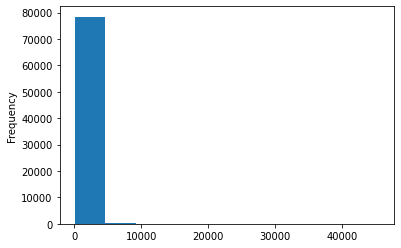

In [ ]:
df['Sentence'].apply(lambda x: len(str(x))).plot(kind='hist');

In [ ]:
df.Sentiment.reset_index(drop=True, inplace=True)

In [ ]:
df.Sentiment.value_counts()

9     18558
11    11296
4     10706
5      8951
2      8199
0      6126
7      5036
6      3754
3      3389
10     2810
Name: Sentiment, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


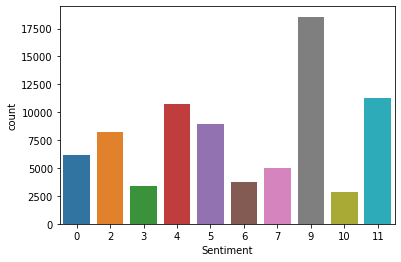

In [ ]:
sns.countplot(df['Sentiment']);

# **bnltk 0.7.6 Stemmer**

**New Stemmed**

In [ ]:
uniqueWords = list(set(" ".join(df['Sentence']).split(" ")))
count = len(uniqueWords)
print(count)

271263


In [ ]:
df['Sentence'] = df['Sentence'].astype('str') 
df.reset_index(drop=True, inplace=True)
#df['Sentence'] = df['Sentence'].astype('str')

In [ ]:

#df['Sentence'] = df.Sentence.apply(lambda x: Stemming(str(x)))

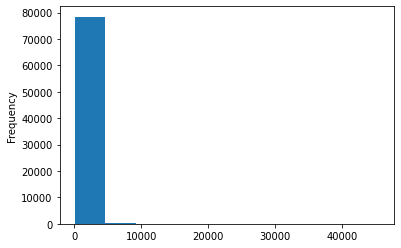

In [ ]:
df['Sentence'].apply(lambda x: len(str(x))).plot(kind='hist');

In [ ]:
from collections import Counter
#Counter(" ".join(df["Sentence"]).split()).most_common(1000)  
#NOT FASTER 

In [ ]:
#pd.Series(' '.join(df['Sentence']).lower().split()).value_counts()[:10000] #faster AND for large amounts of text/rows

# **Shuffle the data**

In [ ]:
from sklearn.utils import shuffle
df = shuffle(df)

In [ ]:
df.Sentiment.value_counts()

9     18558
11    11296
4     10706
5      8951
2      8199
0      6126
7      5036
6      3754
3      3389
10     2810
Name: Sentiment, dtype: int64

In [ ]:
train1, test1 = train_test_split(df,random_state=22, test_size=0.2)
training_sentences = []
testing_sentences = []




train_sentences=train1['Sentence'].values
train_labels=train1['Sentiment'].values
#for i in range(train_sentences.shape[0]): 
    #print(train_sentences[i])
 #   x=str(train_sentences[i])
 #   training_sentences.append(x)

 
    
#training_sentences=np.array(training_sentences)





test_sentences=test1['Sentence'].values
test_labels=test1['Sentiment'].values
#y = pd.get_dummies(data1['Sentiment']).values

train_labels=pd.get_dummies(train_labels).values
test_labels=pd.get_dummies(test_labels).values


print("Training Set Length: "+str(len(train1)))
print("Testing Set Length: "+str(len(test1)))
print("training_sentences shape: "+str(train_sentences.shape))
print("testing_sentences shape: "+str(test_sentences.shape))
print("train_labels shape: "+str(train_labels.shape))
print("test_labels shape: "+str(test_labels.shape))


Training Set Length: 63060
Testing Set Length: 15765
training_sentences shape: (63060,)
testing_sentences shape: (15765,)
train_labels shape: (63060, 10)
test_labels shape: (15765, 10)


In [ ]:
train_labels

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
print(train_sentences[10])
print(train_labels[0])

এম মহীউদ্দিন পদোন্নতি গ্রামীণ ব্যাংক উপব্যবস্থাপনা পরিচালক প্রতিষ্ঠান প্রশাসন মহাব্যবস্থাপক সাল গ্রামীণ ব্যাংক প্রকল্প মাঠ ব্যবস্থাপক পদ যোগ মহীউদ্দিন চট্টগ্রাম বিশ্ববিদ্যাল বাংলা ভাষা সাহিত্য সম্মানসহ স্নাতকোত্তর ডিগ্রি অর্জন গ্রামীণ ব্যাংক কর্মসূচি উপস্থাপনসহ অনুষ্ঠান যোগ দেশ সফর বিজ্ঞপ্তি
[0 0 1 0 0 0 0 0 0 0]


In [ ]:
vocab_size = 200000
embedding_dim = 300
max_length = 4000
trunc_type='post'
oov_tok = "<OOV>"

In [ ]:
print(train_sentences.shape)
print(train_labels.shape)

(63060,)
(63060, 10)


In [ ]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

#451606 words in raw dataset
#434245 words in raw dataset after stopwords removal
#339313 after stemming 

print(len(word_index))
print("Word index length:"+str(len(tokenizer.word_index)))
sequences = tokenizer.texts_to_sequences(train_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)


test_sequences = tokenizer.texts_to_sequences(test_sentences)
testing_padded = pad_sequences(test_sequences,maxlen=max_length)

239719
Word index length:239719


In [ ]:
print("Sentence :--> \n")
print(train_sentences[2]+"\n")
print("Sentence Tokenized and Converted into Sequence :--> \n")
print(str(sequences[2])+"\n")
print("After Padding the Sequence with padding length 100 :--> \n")
print(padded[2])

Sentence :--> 

রোবব বেলা সোয়া মৈত্রী নার্সি হোম মালিক ডা গৌরাঙ্গ চন্দ্র দাস নার্সিং হোম ওয়ার্ড রাস খুন পুলিশ খানজাহান আলী থান ওসি মো শহীদুল হক জানান রাস ওখানক নার্স প্রেম সম্পর্ক ডা গৌরাঙ্গ কয়েকদিন রাস সম্পর্ক বিরত থাক নির্দেশ ক্ষিপ্ত রাস ধারালো অস্ত্র ডা গৌরাঙ্গ কুপি পা উদ্ধ খুলনা মেডিক কলেজ হাসপাতাল নেয়া কর্তব্যরত চিকিৎসক মৃত লাশ ময়নাতদন্ত হাসপাতাল মর্গ রাস গ্রেপ্ত অভিযান জানান ওসি

Sentence Tokenized and Converted into Sequence :--> 

[91, 234, 1393, 5146, 119344, 3886, 421, 827, 15887, 947, 1452, 8743, 3886, 1487, 1016, 301, 12, 15684, 143, 120, 180, 86, 1832, 97, 6, 1016, 20995, 8744, 1011, 376, 827, 15887, 1982, 1016, 376, 2944, 99, 334, 6286, 1016, 2763, 505, 827, 15887, 1854, 15, 166, 734, 281, 80, 72, 468, 1971, 472, 894, 183, 1666, 72, 1054, 1016, 112, 356, 6, 180]

After Padding the Sequence with padding length 100 :--> 

[  0   0   0 ... 356   6 180]


In [ ]:
print("Padded shape(training): "+str(padded.shape))
print("Padded shape(testing): "+str(testing_padded.shape))

Padded shape(training): (63060, 4000)
Padded shape(testing): (15765, 4000)


In [ ]:

model= Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(Conv1D(200, kernel_size=3, activation = "relu"))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Flatten())
#l2 regularizer
model.add(Dense(100,kernel_regularizer=regularizers.l2(0.01),activation="relu"))
model.add(Dense(10, activation='softmax'))
#sgd= SGD(lr=0.0001,decay=1e-6,momentum=0.9,nesterov=True)
adam=Adam(learning_rate=0.0005,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False)
model.summary()
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 4000, 300)         60000000  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3998, 200)         180200    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 3998, 128)         135680    
_________________________________________________________________
dropout_1 (Dropout)          (None, 3998, 128)         0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_4 (Dense)              (None, 50)                6450      
_________________________________________________________________
dense_5 (Dense)              (None, 50)               

In [ ]:
history=model.fit(padded,train_labels,epochs=5,batch_size=128,validation_data=(testing_padded,test_labels),use_multiprocessing=True, workers=8)

Epoch 1/5
493/493 [==============================] - 945s 2s/step - loss: 1.9518 - accuracy: 0.4682 - val_loss: 0.8864 - val_accuracy: 0.7666
Epoch 2/5
493/493 [==============================] - 898s 2s/step - loss: 0.8040 - accuracy: 0.7859 - val_loss: 0.6916 - val_accuracy: 0.8224
Epoch 3/5
493/493 [==============================] - 894s 2s/step - loss: 0.5394 - accuracy: 0.8693 - val_loss: 0.5443 - val_accuracy: 0.8643
Epoch 4/5
493/493 [==============================] - 894s 2s/step - loss: 0.3517 - accuracy: 0.9193 - val_loss: 0.4779 - val_accuracy: 0.8839
Epoch 5/5
493/493 [==============================] - 896s 2s/step - loss: 0.2460 - accuracy: 0.9464 - val_loss: 0.4892 - val_accuracy: 0.8856


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


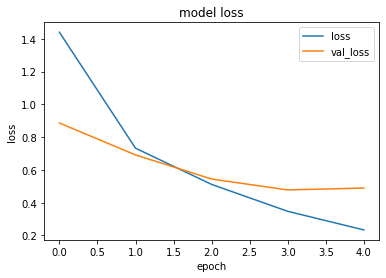

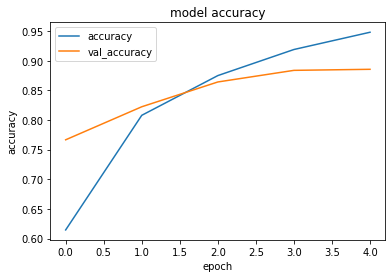

In [ ]:
print(history.history.keys())
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'])
plt.show()

accuracy = history.history['accuracy']
val_accuracy= history.history['val_accuracy']
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [ ]:
#accuracy calculation
loss_and_metrics = model.evaluate(padded,train_labels,batch_size=128)
print("The train accuracy is: "+str(loss_and_metrics[1]))
loss_and_metrics = model.evaluate(testing_padded,test_labels,batch_size=128)
print("The test accuracy is: "+str(loss_and_metrics[1]))

493/493 [==============================] - 241s 488ms/step - loss: 0.1656 - accuracy: 0.9666
The train accuracy is: 0.966619074344635
124/124 [==============================] - 60s 485ms/step - loss: 0.4892 - accuracy: 0.8856
The test accuracy is: 0.8856327533721924


In [ ]:
predictions = model.predict(testing_padded)
pred1 = np.argmax(predictions , axis=1)

In [ ]:
%%time
score = model.evaluate(testing_padded, test_labels , batch_size = 128)
print()

print("ACCURACY:",score[1])
print("LOSS:",score[0])

124/124 [==============================] - 61s 487ms/step - loss: 0.4892 - accuracy: 0.8856

ACCURACY: 0.8856327533721924
LOSS: 0.48921188712120056
CPU times: user 52.9 s, sys: 8.63 s, total: 1min 1s
Wall time: 1min 21s


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [ ]:
test_labels = np.argmax(test_labels,axis=1)

In [ ]:
print(confusion_matrix(test_labels , pred1 ,normalize=None))

[[1062   48    0   11    2    6    8   13    5    8]
 [  21 1442    2   23   10   19   36  105    4    4]
 [   0    1  568    4    1   20   42   47    4    1]
 [  10   14    3 1949   29   30    4   95    5   16]
 [   1   11    4   45 1608   41    8   19   34   14]
 [  11   40    8   48   15  487   25  103    5    5]
 [   6   36   15    5   10   20  852   19   16   18]
 [  19   69   36   91   14   32   22 3487    2   10]
 [  10    4    5    5   25   17   59    4  407    6]
 [  35    5    1   27   26    7    7   19   13 2100]]


In [ ]:
print(classification_report(test_labels , pred1))

              precision    recall  f1-score   support

           0       0.90      0.91      0.91      1163
           1       0.86      0.87      0.86      1666
           2       0.88      0.83      0.85       688
           3       0.88      0.90      0.89      2155
           4       0.92      0.90      0.91      1785
           5       0.72      0.65      0.68       747
           6       0.80      0.85      0.83       997
           7       0.89      0.92      0.91      3782
           8       0.82      0.75      0.78       542
           9       0.96      0.94      0.95      2240

    accuracy                           0.89     15765
   macro avg       0.87      0.85      0.86     15765
weighted avg       0.89      0.89      0.89     15765



In [ ]:
accuracy_score(test_labels , pred1)

0.8856327307326356